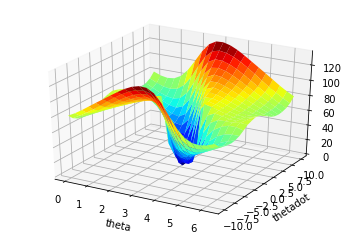

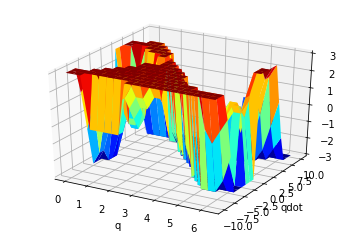

In [13]:
%matplotlib inline
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (DiagramBuilder, SignalLogger, Simulator, VectorSystem)
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer


expmt = "pendulum"
expmt = "double_integrator"


plant = PendulumPlant()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()


def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    if x.dot(x) < .05:
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + u.dot(u)


if (False):
    cost_function = min_time_cost
    input_limit = 1.
    options.convergence_tol = 0.001
else:
    cost_function = quadratic_regulator_cost
    input_limit = 3.
    options.convergence_tol = 0.1

qbins = np.linspace(0., 2. * math.pi, 21)
qdotbins = np.linspace(-10., 10., 21)
state_grid = [set(qbins), set(qdotbins)]
options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(0, 0., 2.*math.pi),
]
input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 10 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                           cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     if plt.get_backend() != u'template':
    plt.draw_all()
    plt.pause(0.00001)

#     surf.remove()
#     surf2.remove()


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)


# Animate the resulting policy.
builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 2, 2)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
        output[0] = output[0] - twoPI * math.floor(output[0] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), pendulum.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0.1, 0.0])

In [9]:
simulator.StepTo(10.)

In [10]:
# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())